# Ajuste de isocronas

Para ajustar las isocronas teóricas, primero se descargan los datos desde la base de datos de PARSEC usando un rango en metalicidad y edad de acuerdo al cúmulo que se quiere estudiar.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

Primero, se leen todas las isocronas que se descargaron y se quita filterslambdas.dat de la lista para evitar problemas.

In [ ]:
isochrones = glob.glob("./isochrones_beehive_2/gaiaedr3/*.dat")
isochrones.remove('./isochrones_beehive_2/gaiaedr3/filterslambdas.dat')

def open_file(x):
    y = pd.read_csv(x, delim_whitespace=True, skiprows=9)
    return y

def change_columns(x):
    y = x.rename(columns={'#':'Zini', 'Zini':'MH', 'MH':'logAge','logAge':'Mini','Mini':'int_IMF',
                          'int_IMF':'Mass','Mass':'logL','logL':'logTe','logTe':'logg','logg':'label',
                          'label':'mbolmag','mbolmag':'Gmag','Gmag':'G_BPmag','G_BPmag':'G_RPmag',
                          'G_RPmag':'delete'})
    return y

def remove_columns(x):
    y = x.drop('delete', axis=1)
    return y

def remove_rows(x):
    y = x.dropna(axis=0, subset=['Gmag'])
    return y


#isoc_data = pd.concat(map(open_file, isochrones[151:204]), ignore_index=True)
isoc_data = pd.concat(map(open_file, isochrones), ignore_index=True)
isoc_data = remove_rows(remove_columns(change_columns(isoc_data)))
#isoc_data.to_csv('./isoc/isoc_data.csv')
print(isoc_data.head())

Es necesario ordenar los archivos, pues todos vienen en archivos separados. Para esto, se concatenan y se ordenar por rango de metalicidad y edad.

Con los archivos ordenados, se seleccionan solo los datos de interés como Zini, logAge, Gmag y BP_RP, y se crea un .csv con solo estos datos. Es necesario eliminar los NA usando la función dropna().

In [ ]:
data = isoc_data #pd.read_csv('./isoc/isoc_data.csv')
data['Zini'] = pd.to_numeric(data['Zini'],errors='coerce')
data['logAge'] = pd.to_numeric(data['logAge'],errors='coerce')
data['Gmag'] = pd.to_numeric(data['Gmag'],errors='coerce')
data['G_BPmag'] = pd.to_numeric(data['G_BPmag'],errors='coerce')
data['G_RPmag'] = pd.to_numeric(data['G_RPmag'],errors='coerce')
#data['bp_rp'] = data['G_BPmag'] - data['G_RPmag'] 
data['BP_RP'] = data['G_BPmag'] - data['G_RPmag']
data = data.dropna(axis=0,subset=['Gmag','G_BPmag','G_RPmag'])
#data = data[data['Gmag'].apply(lambda x: str(x).isdigit())]

data = data[['Zini','logAge','Gmag','BP_RP']].to_csv('./isoc/consolidated_beehive_2.csv')
#data.dropna(axis=0,subset=['Gmag','G_BPmag','G_RPmag'])[['Zini','logAge','Gmag','bp_rp']].to_csv('consolidated.csv')
#print(data.keys())
data

Hasta aquí, se ha generado un archivo que se llama consolidated_'cluster'.csv que tiene los datos de interés.

Si ya se tiene un consolidated_'cluster'.csv, no es necesario correr la parte de arriba.

# Encontrando la mejor isocrona calculando errores

Para calcular la mejor isocrona, se calculan los errores de la isocrona teórica respecto a los datos reales. Al final, se obtiene un .csv con el valor de metalicidad, la edad y su error. Se escoge la que menor error tenga.

In [43]:
df = pd.read_csv('./datos/pleiades_PMmodel.csv')
#print(df['parallax'])

isochrones = pd.read_csv('./isoc/consolidated_pleiades.csv')
isochrones = isochrones[isochrones['Gmag'] > isochrones['BP_RP']]#*7.778068

z_rate = np.sort(isochrones['Zini'].unique())
log_age = np.sort(isochrones['logAge'].unique())

In [44]:
#df['parallax'] = df['parallax']/1000 # solo si no esta en segundos de arco
print(df['parallax'])

0      0.007583
1      0.007735
2      0.007474
3      0.004313
4      0.007308
         ...   
979    0.007236
980    0.006518
981    0.007205
982    0.007246
983    0.007041
Name: parallax, Length: 984, dtype: float64


No handles with labels found to put in legend.


984 984


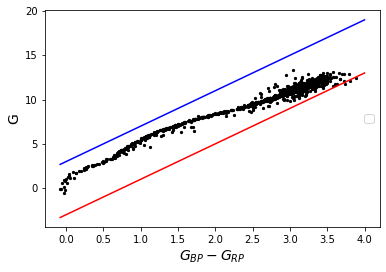

In [45]:
g_mag = df['g'] + 5 - 5*np.log10(1/df['parallax'])
color = df['bp'] - df['rp']

def line(x, m, b):
    return m*x+b

#g_mag = g_mag[(color > 0)]
#color = color[(color > 0)]
print(len(g_mag), len(color))
x = np.linspace(min(color), 4, len(g_mag))
plt.plot(x, line(x,4,3),color='blue')
plt.plot(x, line(x,4,-3),color='red')
plt.scatter(color, g_mag, color='black',s=5)
#plt.gca().invert_yaxis()
plt.xlabel(r"$G_{BP}-G_{RP}$",fontsize=14)
plt.ylabel("G",fontsize=14)
#plt.axvline(0)
plt.legend(fontsize=12,loc=5)

No handles with labels found to put in legend.


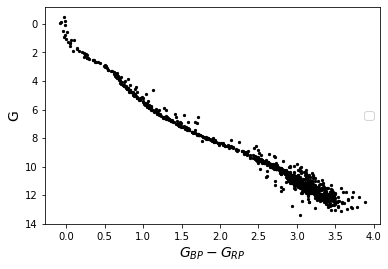

In [46]:
#y_up = line(color,4,3)
#y_down = line(color,4,-3)
#color = color[(g_mag < y_up)]# & (g_mag > y_down)]
#g_mag = g_mag[(g_mag < y_up)]# & (g_mag > y_down)]

g_mag = df['g'] + 5 - 5*np.log10(1/df['parallax'])
color = df['bp'] - df['rp']

plt.scatter(color, g_mag, color='black',s=5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_{BP}-G_{RP}$",fontsize=14)
plt.ylabel("G",fontsize=14)
#plt.axvline(0)
plt.legend(fontsize=12,loc=5)

In [47]:
from tqdm import tqdm

save_z_rate = []
save_log_age = []
differ = []

#g_mag = df['g'] + 5 - 5*np.log10(1/df['parallax'])
#color = df['bp'] - df['rp']

for i in tqdm(range(len(z_rate))):
    for j in range(len(log_age)):
        isoc_test = isochrones[(isochrones['Zini'] == z_rate[i]) & (isochrones['logAge'] == log_age[j])]
        isoc_test = np.array(isoc_test)
        for k in range(len(isoc_test)):
            diff = np.sqrt((color - isoc_test[k,-1])**2 + (g_mag - isoc_test[k,-2])**2)
        differ.append(min(diff))
        save_z_rate.append(z_rate[i])
        save_log_age.append(log_age[j])

100%|██████████| 20/20 [06:17<00:00, 18.87s/it]


In [48]:
data = {'z_rate':save_z_rate,'log_age':save_log_age,'min_difference':differ}

data_f = pd.DataFrame(data)
data_f.to_csv('./isoc/results_pleiades_pm.csv')

data_f = pd.read_csv('./isoc/results_pleiades_pm.csv')
#data_result = data_dbscan[data_dbscan['error']>0.0]
print(data_f.sort_values(by='min_difference').head(10))

      Unnamed: 0  z_rate  log_age  min_difference
6583        6583   0.046  8.32996        0.001341
6584        6584   0.046  8.33196        0.001804
4850        4850   0.036  8.37396        0.001984
2775        2775   0.024  8.43595        0.002321
5888        5888   0.042  8.34396        0.002321
6239        6239   0.044  8.34396        0.002692
2776        2776   0.024  8.43795        0.002730
4849        4849   0.036  8.37196        0.002794
6230        6230   0.044  8.32596        0.002829
6238        6238   0.044  8.34196        0.003110


In [49]:
test_isoc = np.array(data_f.sort_values(by='min_difference'))
test_isoc

array([[6.58300000e+03, 4.60000000e-02, 8.32996000e+00, 1.34127655e-03],
       [6.58400000e+03, 4.60000000e-02, 8.33196000e+00, 1.80352035e-03],
       [4.85000000e+03, 3.60000000e-02, 8.37396000e+00, 1.98368918e-03],
       ...,
       [1.90000000e+01, 1.00000000e-02, 7.83800000e+00, 1.69081409e-01],
       [2.50000000e+01, 1.00000000e-02, 7.85000000e+00, 1.69933213e-01],
       [1.80000000e+01, 1.00000000e-02, 7.83600000e+00, 1.70827643e-01]])

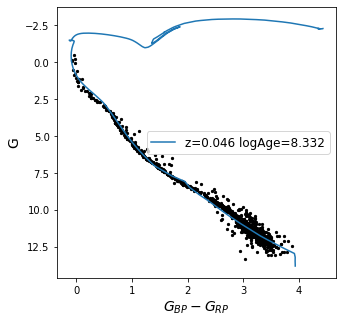

In [52]:
isochrones = pd.read_csv('./isoc/consolidated_pleiades.csv')
#df = pd.read_csv('./datos/blanco1_PMmodel.csv')

#g_mag = df['g'] + 5 - 5*np.log10(1 / df['parallax'])
pos = 1
isochrones = isochrones[(isochrones['Zini']==test_isoc[pos][1]) & (isochrones['logAge']==test_isoc[pos][2])]

plt.figure(figsize=(5,5))
plt.plot(isochrones['BP_RP'], isochrones['Gmag'],
         label=r'z={} logAge={:.5}'.format(test_isoc[pos][1],test_isoc[pos][2]))
plt.scatter(df['bp'] - df['rp'], g_mag, color='black',s=5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_{BP}-G_{RP}$",fontsize=14)
plt.ylabel("G",fontsize=14)
#plt.axvline(0)
plt.legend(fontsize=12,loc=5)
plt.savefig('./imagenes/isocrona_pleiades_pm.png',bbox_inches='tight')

In [ ]:
df = pd.read_csv('./blanco1_dbscan.csv')

isochrones = pd.read_csv('./isoc/consolidated_blanco1_2.csv')
isochrones = isochrones[isochrones['Gmag'] > isochrones['BP_RP']]#*7.778068

z_rate = np.sort(isochrones['Zini'].unique())
log_age = np.sort(isochrones['logAge'].unique())


global_errors=[]
save_z_rate =[]
save_log_age=[]
g_mag = df['g'] + 5 - 5*np.log10(1/df['parallax'])

for i in tqdm(range(len(z_rate))):
    for j in range(len(log_age)):
        error_isoc = 0
        isoc_test = isochrones[(isochrones['Zini'] == z_rate[i]) & (isochrones['logAge'] == log_age[j])]
        isoc_test = np.array(isoc_test)
        for k in range(len(isoc_test)):
            diff = abs((df['bp'] - df['rp']) - isoc_test[k,-1]).argmin()
            error_isoc += (g_mag[diff] - isoc_test[k,-2])**2
        global_errors.append(error_isoc)
        #save_cluster.append(clusters_names[cd])
        save_z_rate.append(z_rate[i])
        save_log_age.append(log_age[j])

In [ ]:
data = {'z_rate':save_z_rate,'log_age':save_log_age,'error':diff}

data_f = pd.DataFrame(data)
data_f.to_csv('./isoc/results_blanco1_dbscan_2.csv')

data_result = pd.read_csv('./isoc/results_blanco1_dbscan_2.csv')
#data_result = data_dbscan[data_dbscan['error']>0.0]
print(data_result.sort_values(by='error').head(30))

In [ ]:
isochrones = pd.read_csv('./isoc/consolidated_blanco1_2.csv')
df = pd.read_csv('./blanco1_dbscan.csv')

g_mag = df['g'] + 5 - 5*np.log10(1 / df['parallax'])
pos = 1
isochrones = isochrones[(isochrones['Zini']==test_isoc[pos][1]) & (isochrones['logAge']==test_isoc[pos][2])]

plt.figure(figsize=(5,5))
plt.plot(isochrones['BP_RP'], isochrones['Gmag'], label=r'z={} logAge={:.5}'.format(test_isoc[pos][1],test_isoc[pos][2]))
plt.scatter(df['bp'] - df['rp'], g_mag, color='black',s=5)
plt.gca().invert_yaxis()
plt.xlabel(r"$G_{BP}-G_{RP}$",fontsize=14)
plt.ylabel("G",fontsize=14)
plt.legend(fontsize=12,loc=0)
#plt.savefig('./isocrona_blanco1.png',bbox_inches='tight')